In [2]:
% matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from IPython.display import Image


# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from glycemic_patterns.model import Translator
import glycemic_patterns.preprocessor as pp


# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Define language and translator functions
language = "es"
translator = Translator(language)
to_lang = translator.translate_to_language
to_col = translator.translate_to_column

# Load data
raw_data = pd.read_csv("data/ACN_20160331_20160414_FREE_STYLE.txt", header=0, skiprows=1, delimiter="\t", index_col=0, usecols=list(range(0, 9)),
                       parse_dates=to_lang(["Datetime"]), decimal=",",
                       date_parser=lambda x: pd.to_datetime(x, format="%Y/%m/%d %H:%M"))
# Translate column names
raw_data.columns = (to_col(raw_data.columns))

# Divide in blocks, extend dataset and clean data
block_data,block_info = pp.define_blocks(raw_data)

In [3]:
import datetime

def smooth_plot(data):
    # Level of granularity of time axis (Time difference between points)
    interval_min = 1

    # Define bounds of the plot
    min_time = data["Datetime"].min()
    max_time = data["Datetime"].max()

    difference = (max_time - min_time + datetime.timedelta(minutes=1))
    min_diff = (difference.days * 24 * 60) + (difference.seconds / 60)

    smoothed_data = pd.DataFrame((min_time + datetime.timedelta(minutes=x * interval_min)
                                  for x in range(0, int((min_diff / interval_min)))), columns=["Datetime"])
    smoothed_data = pd.merge(smoothed_data, data, how='left', on="Datetime")

    # Cubic spline interpolation
    smoothed_data["Glucose_Auto"] = smoothed_data["Glucose_Auto"].interpolate(method='cubic')

    # Propagate Block and Day_Block data
    smoothed_data.fillna(method='pad', inplace=True, downcast='infer')

    return smoothed_data

In [17]:
def plot_blocks(data, init_day, translator, end_day=None):
    if end_day == None:
        end_day = init_day

    # Check if it is only one day
    if init_day == end_day:
        one_day = True
    else:
        one_day = False

    # Convert init_day and end_day to datetime.day
    if not isinstance(init_day, datetime.date):
        if isinstance(init_day, datetime):
            init_day = init_day.date()
        else:
            raise TypeError("init_day must be a datetime object")

    if not isinstance(end_day, datetime.date):
        if isinstance(end_day, datetime):
            end_day = end_day.date()
        else:
            raise TypeError("end_day must be a datetime object")

    # Get sample from init_datetime to end_datetime
    auto_gluc_blocks_sample = data[(data["Day_Block"] >= init_day) & (data["Day_Block"] <= end_day)]

    # Smooth glucose data
    smoothed_sample = smooth_plot(auto_gluc_blocks_sample)

    # Generate figure
    fig, ax = plt.subplots()
    labels = []
    for key, grp in smoothed_sample.groupby(['Block', 'Day_Block']):
        ax = grp.plot(ax=ax, kind='line', x="Datetime", y="Glucose_Auto")
        if one_day:
            labels.append("{} {:d}".format(translator.translate_to_language(["Block"])[0], key[0]))
        else:
            labels.append("{} {:d} ({:%d/%m}) ".format(translator.translate_to_language(["Block"])[0], key[0], key[1]))
    lines, _ = ax.get_legend_handles_labels()
    if one_day:
        ax.legend(lines, labels, loc='best')
    else:
        ax.legend(lines, labels)
    plt.show()

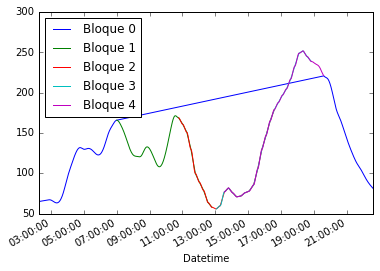

In [18]:
plot_blocks(block_data, datetime.date(2016, 4, 2), translator)

In [19]:
def plot_blocks(data, init_day, translator, end_day=None):
    if end_day == None:
        end_day = init_day

    # Check if it is only one day
    if init_day == end_day:
        one_day = True
    else:
        one_day = False

    # Convert init_day and end_day to datetime.day
    if not isinstance(init_day, datetime.date):
        if isinstance(init_day, datetime):
            init_day = init_day.date()
        else:
            raise TypeError("init_day must be a datetime object")

    if not isinstance(end_day, datetime.date):
        if isinstance(end_day, datetime):
            end_day = end_day.date()
        else:
            raise TypeError("end_day must be a datetime object")

    # Get sample from init_datetime to end_datetime
    auto_gluc_blocks_sample = data[(data["Day_Block"] >= init_day) & (data["Day_Block"] <= end_day)]
    block_info_sample = block_info[(block_info["Day_Block"] >= init_day) & (block_info["Day_Block"] <= end_day)]
    
    # Smooth glucose data
    smoothed_sample = smooth_plot(auto_gluc_blocks_sample)

    # Generate figure
    fig, ax = plt.subplots()
    labels = []
    for key, grp in smoothed_sample.groupby(['Block','Day_Block']):
        grp_axis = smoothed_sample[smoothed_sample['Day_Block']==key[1]]
        grp_axis.loc[grp_axis['Block']!= key[0],"Glucose_Auto"] = np.nan
        if one_day:
            label= "{} {:d}".format(translator.translate_to_language(["Block"])[0], key[0])
        else:
            labels= "{} {:d} ({:%d/%m}) ".format(translator.translate_to_language(["Block"])[0], key[0], key[1])
        ax=grp_axis.plot(ax=ax,kind='line', x="Datetime", y="Glucose_Auto", label=label)
    for i, dt in enumerate(block_info_sample["Datetime"]):
        plt.axvline(dt, color='grey', linestyle='--',label='Meal'if i == 0 else "")
    if one_day:
        ax.legend(loc='best')
    else:
        ax.legend()
    plt.show()

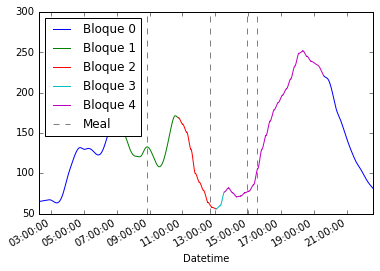

In [20]:
plot_blocks(block_data, datetime.date(2016, 4, 2), translator)